Попытка решить проблему слишком большого количества классов

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [348]:
# количество итераций обучения
NUM_OF_ITERATIONS = 50

# читаем размеченные данные из файла
beer_dataset = pd.read_excel('beer_data_set.xlsx')

# печатаем список колонок таблички чтобы удобнее было копировать
print('\n'.join(beer_dataset.columns))

# выводим несколько первых строк таблицы
beer_dataset.head()

barcode
SKU_NAME
Наименование
Алкоголь
Объем
Производитель
Бренд
Саб-бренд
Тип упаковки
Мультипак
тип


,barcode,SKU_NAME,Наименование,Алкоголь,Объем,Производитель,Бренд,Саб-бренд,Тип упаковки,Мультипак,тип
0,4600721002206,Пиво БагБир 0.5л ст/бут,BAGBIER - светлое - 4.2% - 0.5л стекло,0.042,0.5,AB InBev,BAGBIER,NaN,Стекло,NaN,Светлое
1,4600721003197,Пиво БАГ-БИР св.ст/б 0.5л,BAGBIER - светлое - 4.2% - 0.5л стекло,0.042,0.5,AB InBev,BAGBIER,NaN,Стекло,NaN,Светлое
2,4600721003203,"Пиво BAGBIER светлое 4,9% 1.5л",BAGBIER - светлое - 4.9% - 1.5л пэт,0.049,1.5,AB InBev,BAGBIER,NaN,ПЭТ,NaN,Светлое
3,4600721005191,Пиво БАГ-БИР св.ПЭТ 2.5л,BAGBIER - светлое - 4.2% - 2.5л пэт,0.042,2.5,AB InBev,BAGBIER,NaN,ПЭТ,NaN,Светлое
4,4600721009366,"Пиво БАГ БИР ГОЛЬДЕН светлое ПЭТ 4% 1,5л",BAGBIER GOLDEN - светлое - 4.7% - 1.5л пэт,0.047,1.5,AB InBev,BAGBIER,Golden,ПЭТ,NaN,Светлое


In [398]:
data = [item for item in beer_dataset[['SKU_NAME']].values.flatten()]
labels = [item.lower() for item in beer_dataset['Бренд'].values.flatten()]

In [404]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, normalize
from joblib import dump, load
from itertools import chain 

class BrandPredictor:
    def __init__(vect, le, clf, hist):
        self.vect = vect
        self.le = le
        self.clf = clf
        self.hist = hist
        
    def save(self, name):
        self.clf.save_weights(f"{name}_weights.h5")
        with open(f"{name}_layers.json", 'w', encoding='UTF8') as layers_file:
            layers_file.write(self.clf.to_json())
        dump(self.vect, f"{name}_vect.joblib") 
        dump(self.le, f"{name}_le.joblib")
    
    def vectorizer(token_pattern=r"(?m)[a-zA-Zа-яА-Я]+|[0-9]+[\.,][0-9]+[\w\%]|[0-9]+[\.,][0-9]+"):
        return CountVectorizer(lowercase=True,
                                max_df=0.4,
                                analyzer='word',
                                stop_words=['пиво'],
                                token_pattern=token_pattern)
    
    def build_default(data, labels, val=None, epochs=10, batch_size=32):
        if not val:
            data, val_data, labels, val_labels = BrandPredictor.split(data, labels)
            val = (val_data, val_labels)
            
        vect = BrandPredictor.vectorizer()
        vect.fit(chain(data, val[0]))
        vect_data = vect.transform(data).todense()
        vect_val_data = vect.transform(val[0]).todense()
        
        le = LabelEncoder() 
        le.fit(labels + val[1])
        enc_labels = BrandPredictor.encode_labels(le, labels)
        env_val_labels = BrandPredictor.encode_labels(le, val[1])
        
        clf = Sequential()
        input_dim = vect_data.shape[1]
        classes = enc_labels.shape[1]
        for layer in [
            Dense(input_dim, input_dim=input_dim),
            Dense(classes, activation='softmax')
        ]: classifier.add(layer) 
        
        clf.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        
        hist = clf.fit(vect_data, enc_labels,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=val)
        return BrandPredictor.__init__(vect, le, clf, hist)
        
    def split(data, labels, test_size=0.33, random_state=42):
        return train_test_split(data, labels, test_size=test_size, random_state=random_state)

    def encode_labels(le, labels):
        return to_categorical(le.fit_transform(labels))
    
    def decode_labels(self, encoded_labels):
        return self.le.inverse_transform(encoded_labels).flatten()
    
    def predict(self, data):
        vectorized_data = self.vect.transform(data)
        encoded_predictions = self.clf.predict(vectorized_data)
        return ((self.le.inverse_transform(p.argmax()), p.max())
                   for p in encoded_predictions)
    
model = BrandPredictor.build_default(data, labels)

ValueError: Error when checking target: expected sequential_48_input to have shape (2059,) but got array with shape (441,)

In [349]:
import re 
import random
import time
from json import dumps

random.seed(time.time())
analyzer = 'word'
token_pattern = r"(?m)[a-zA-Zа-яА-Я]+|[0-9]+[\.,][0-9]+[\w\%]|[0-9]+[\.,][0-9]+"

def quote(s):
    return s

def tokenize(items, token_pattern):
    pat = re.compile(token_pattern)
    tokens = ['; '.join(quote(match.group()) for match in re.finditer(pat, item)) for item in items ]
    data = zip(items, tokens)
    return pd.DataFrame(data, columns=['Строка', 'Токены'])

tokenize(random.sample(data, 10), token_pattern)

,Строка,Токены
0,"Пиво САМАРА КЛАССИЧ.св.4,7% 0.47л","Пиво; САМАРА; КЛАССИЧ; св; 4,7%; 0.47л"
1,Пиво РИЖСКОЕ ВК.ВОСП.непаст.5% ст/б 0.5л,Пиво; РИЖСКОЕ; ВК; ВОСП; непаст; ст; б; 0.5л
2,Пиво БАЛТИКА №6 ст/б 0.5л,Пиво; БАЛТИКА; ст; б; 0.5л
3,SIBIRSKAYA KORONA(AB INBEV) KLASSICHESKOE 0.5L...,SIBIRSKAYA; KORONA; AB; INBEV; KLASSICHESKOE; ...
4,PIKUR KLASSICHESKOE 1L NF L X,PIKUR; KLASSICHESKOE; L; NF; L; X
5,GROTWERG - светлое 4.9% - 0.5л ж.б.,GROTWERG; светлое; 4.9%; 0.5л; ж; б
6,ЗОЛОТАЯ БОЧКА - светлое 4.7% - 0.45л ж.б.,ЗОЛОТАЯ; БОЧКА; светлое; 4.7%; 0.45л; ж; б
7,MYUNKHENSKOE(UDACHA/OMSK) ZHIVOE 1.5L P BO L X,MYUNKHENSKOE; UDACHA; OMSK; ZHIVOE; 1.5L; P; B...
8,T 6X0.5L T B L X,T; X; 0.5L; T; B; L; X
9,BULGARPIVO BARKHATNOE 1.5L P BO D X,BULGARPIVO; BARKHATNOE; 1.5L; P; BO; D; X


In [392]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

data = [item for item in beer_dataset[['SKU_NAME']].values.flatten()]
labels = [item.lower() for item in beer_dataset['Бренд'].values.flatten()]
full_train_data, test_data, full_train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

delim = len(full_train_data)//4

train_data, val_data = full_train_data[delim:], full_train_data[:delim]
train_labels, val_labels = full_train_labels[delim:], full_train_labels[:delim]

def intersect(doc, label):
    doc_tokens = set(doc.lower().split())
    label_tokens = set(label.lower().split())
    if len(doc_tokens.intersection(label_tokens)) > 0:
        return 1
    return 0

def enrich(vectors, data, labels):
    padding = np.array([[intersect(data[i], label) for i, label in enumerate(labels)]]).transpose()
    enriched = np.concatenate((vectors.todense(), padding), axis=1)
    return normalize(enriched, axis=1)

def build_model(data, labels, val_data, val_labels, iterations=200):
        vectorizer = CountVectorizer(lowercase=True,
                                    max_df=0.4,
                                    analyzer='word',
                                    stop_words=['пиво'],
                                    token_pattern=token_pattern)
        vectorizer.fit(data+val_data)
        vectorized_data = enrich(vectorizer.transform(data), data, labels)
        vectorized_val_data = enrich(vectorizer.transform(val_data), val_data, val_labels)
            
        le = LabelEncoder()
        le.fit(labels+val_labels)
        encoded_labels = to_categorical(le.transform(labels))
        encoded_val_labels = to_categorical(le.transform(val_labels))
        # encoded_labels = to_categorical(labels)
        # encoded_val_labels = to_categorical(val_labels)
        
        input_dim = vectorized_data.shape[1]
        classes = encoded_labels.shape[1]
        dropout = 0.3
        
        classifier = Sequential()
        for layer in [
            Dense(input_dim, input_dim=input_dim),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
            Dense(classes, activation='softmax')
        ]: classifier.add(layer)
            
        classifier.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        classifier.summary()
        h = classifier.fit(vectorized_data, 
                           encoded_labels, 
                           epochs=10, 
                           batch_size=32,
                          validation_data=(vectorized_val_data, encoded_val_labels))
        return (vectorizer, 
                le, 
                classifier, 
                h)
    
build_model(data, labels, test_data, test_labels)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 2060)              4245660   
_________________________________________________________________
dense_149 (Dense)            (None, 495)               1020195   
Total params: 5,265,855
Trainable params: 5,265,855
Non-trainable params: 0
_________________________________________________________________
Train on 5824 samples, validate on 1922 samples
Epoch 1/10
5824/5824 [==============================] - 33s 6ms/step - loss: 3.9835 - acc: 0.3480 - val_loss: 2.3918 - val_acc: 0.6629- loss: 3.9955 - acc: 0.34
Epoch 2/10
5824/5824 [==============================] - 19s 3ms/step - loss: 1.8553 - acc: 0.7488 - val_loss: 1.2219 - val_acc: 0.8429
Epoch 3/10
5824/5824 [==============================] - 20s 3ms/step - loss: 1.0450 - acc: 0.8618 - val_loss: 0.7331 - val_acc: 0.9027
Epoch 4/10
5824/5824 [===========================

(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                 lowercase=True, max_df=0.4, max_features=None, min_df=1,
                 ngram_range=(1, 1), preprocessor=None, stop_words=['пиво'],
                 strip_accents=None,
                 token_pattern='(?m)[a-zA-Zа-яА-Я]+|[0-9]+[\\.,][0-9]+[\\w\\%]|[0-9]+[\\.,][0-9]+',
                 tokenizer=None, vocabulary=None),
 LabelEncoder(),
 <keras.callbacks.History at 0x16677ad4c18>)

In [397]:
model = BrandPredictor.build_default(data, labels)

(3902, 2059)
(3902, 441)


ValueError: Error when checking target: expected sequential_44_input to have shape (2059,) but got array with shape (441,)

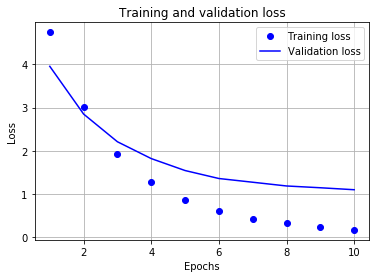

In [352]:
import seaborn as sb
history = model[3]

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

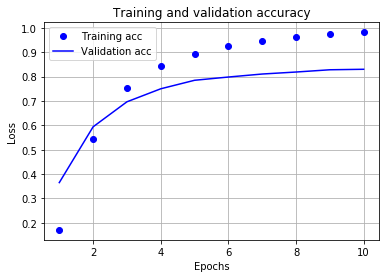

In [353]:
plt.clf()   # clear figure
acc_values =  history.history['acc']
val_acc_values =  history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [368]:
(vectorizer, le, classifier, h) = model
xx = enrich(vectorizer.transform(test_data), test_data, test_labels)

predictions = [(pred.argmax(), pred.max()) for pred in classifier.predict(xx)]

probs = np.array([pred[1] for pred in predictions])


decoded_predictions = le.inverse_transform(np.array([pred[0] for pred in predictions])).flatten()

invalid_probs = np.array([prob for i, prob in enumerate(probs)
                          if decoded_predictions[i] != test_labels[i]])

valid = sum(1 for i, prediction in enumerate(decoded_predictions)
           if prediction == test_labels[i])
print(f"Valid answers: {100*valid/len(test_data)}%")

invalid_preds = [(test_data[i], prediction, 100*predictions[i][1], test_labels[i]) 
                 for i, prediction in enumerate(decoded_predictions)
                 if prediction != test_labels[i]]

invalid = pd.DataFrame(invalid_preds, columns=['Входные данные', 'Предсказание', 'Уверенность', 'Правильный ответ'])

print(np.median(invalid_probs))
fixable_invalid_probs = np.array([prob for i, prob in enumerate(probs)
                          if decoded_predictions[i] != test_labels[i] and intersect(test_labels[i], test_data[i])])
print(np.median(fixable_invalid_probs))
invalid.head(50)

Valid answers: 84.18314255983351%
0.10742092
0.064883634


,Входные данные,Предсказание,Уверенность,Правильный ответ
0,"ПивоANDECH.ВАЙСБ.ХЕФЕТР.св.5,5%ст/б 0.5л",hacker-pschorr,4.516036,andechser vollbier hell
1,ZOLOTOY KHMEL SVETLOE 0.5L J BO L X,джой,9.167177,золотой хмель
2,ВОЛКОВСКАЯ ПИВОВАРНЯ - нефильтрованное светлое...,oettinger,18.976605,волковская пивоварня
3,"Пиво ГУЛЬДЕН ДРААК тем.10,5% ст/б 0.75л",dominus,6.509652,gulden draak
4,OBOLON`(MOSK.PIV.KO.) SVETLOE 2L P BO L C,hollandia,22.118059,оболонь
5,Пиво СОКОЛ Класс.5% св.бут 0.5л,staropramen,7.371974,efes
6,BIZON(OSHA/OMSK) SVETLOE 1.4L P BO L X,чешское,10.517298,bison
7,"Пиво САМКО ПЕНЗА-ПРЕМ.4,3% ст/б 0.5л",самко,44.987145,пенза
8,Нап.БОЙЛЕРМ.ОТ ТУБ.ос.пива 7% ст/б 0.45л,tuborg,33.535656,boilermaker
9,DARYAL BAVARSKOE 1.5L P BO L X,баварское,38.016653,дарьял


In [369]:
fixable = invalid[invalid.apply(lambda df: df['Правильный ответ'] in df['Входные данные'].lower(), axis=1)]
column_intersect = lambda df: intersect(df['Входные данные'], df['Правильный ответ'])
fixable['intersect'] = fixable.apply(column_intersect, axis=1)
print(len(fixable)/len(invalid))
fixable

d:\distrib\anaconda3\envs\beer\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.46710526315789475


,Входные данные,Предсказание,Уверенность,Правильный ответ,intersect
2,ВОЛКОВСКАЯ ПИВОВАРНЯ - нефильтрованное светлое...,oettinger,18.976605,волковская пивоварня,1
7,"Пиво САМКО ПЕНЗА-ПРЕМ.4,3% ст/б 0.5л",самко,44.987145,пенза,0
10,Пиво КОЛЬСКОЕ ПОМОРСК.ЖИВ.св.непаст.1.5л,междуреченское,6.058715,кольское,1
11,ТВЕРДЫЙ ЗНАК - светлое 4.8% - 0.45л стекло,свердловское,6.015901,твердый знак,1
13,Пиво ЛЕДОКОЛ св.8% ст/б 0.5л,сыктывкарское,2.570051,ледокол,1
14,KAUFMANN SVETLOE 1L NF L X,лакинское,4.649810,kaufmann,1
16,"Нап.пивн.BOMBARDIER 5,2% ст/б 0.5л",carling,4.310510,bombardier,0
17,"Пиво ВОРОНЕЖСКИЙ ПИВЗАВОД св.5,7% 0.47л",пикур,2.688330,воронежский пивзавод,1
18,Пиво ТЕТЕРЕВ св.паст.фил.8% 0.48л,gosser,5.804246,тетерев,1
19,"Пиво светлое Крымская Ривьера 5% 0,5 СТ",свердловское,1.871647,крымская ривьера,1
